# Using different network architectures classify traffic signs

In this notebook I will implement and train various different network architectures for classfiying traffic signs. The main focus of this notebook is to explore different network architectures for me to better understand them. Therefore not much emphasis will be put on the preprocessing step e.g. deciding which color space to use, and so forth.

---
## Step 0: Load The Data

In [1]:
import pickle
import cv2

training_file = "train.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

In [2]:
import numpy as np


n_train = train['features'].shape[0]

n_test = test['features'].shape[0]

image_shape = train['features'].shape

n_classes = len(np.unique(test['labels']))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (39209, 32, 32, 3)
Number of classes = 43


In [3]:
import matplotlib.pyplot as plt
import random

# Visualizations will be shown in the notebook.
%matplotlib inline

<Container object of 43 artists>

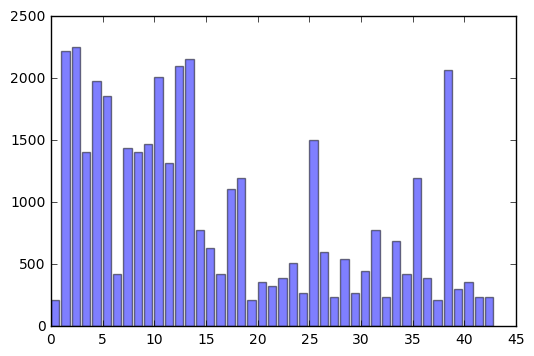

In [4]:
### Lets see the distribution of the images
counts_per_class = []
classes = range(n_classes)
for i in classes:
    count = (y_train == i).sum()
    counts_per_class.append(count)

y_pos = np.arange(n_classes)

plt.bar(y_pos, counts_per_class, alpha = 0.5)

----

## Step 2: Image Preprocessing

In [5]:
# Convert images from RGB to YUV
def rgb2yuv(images):
    
    rgb2yuv_matrix = np.array([[0.299, 0.587, 0.114], [-0.1473, -0.28886, 0.436],[0.615, -0.51499, 0.10001]])
    if len(images.shape) == 3:
        return(np.tensordot(images, rgb2yuv_matrix, axes=([2], [1])))
    else:
        return(np.tensordot(images, rgb2yuv_matrix, axes=([3], [1]))) 

#### Try mean variance scaling

In [6]:
 # Now normalize it by subtracting the mean and dividing by the standard deviation
def normalize_image(images):
    if len(images.shape) == 3:
        channel_1 = images[:,:,0]
        channel_2 = images[:,:,1]
        channel_3 = images[:,:,2]

        # Find the mean and sd
        channel_1_mean = np.mean(channel_1)
        channel_2_mean = np.mean(channel_2)
        channel_3_mean = np.mean(channel_3)
        channel_1_sd = np.sqrt(np.var(channel_1))
        channel_2_sd = np.sqrt(np.var(channel_2))
        channel_3_sd = np.sqrt(np.var(channel_3))

        # Standardize the images
        images[:,:,0] = (images[:,:,0] - channel_1_mean)/channel_1_sd
        images[:,:,1] = (images[:,:,1] - channel_2_mean)/channel_2_sd
        images[:,:,2] = (images[:,:,2] - channel_3_mean)/channel_3_sd
        return(images)
    
    # Get the channel_1channel_2channel_3 colchannel_2mns
    channel_1_col = images[:,:,:,0]
    channel_2_col = images[:,:,:,1]
    channel_3_col = images[:,:,:,2]
    
    # Find the mean and sd
    channel_1_mean = np.mean(channel_1_col)
    channel_2_mean = np.mean(channel_2_col)
    channel_3_mean = np.mean(channel_3_col)
    channel_1_sd = np.sqrt(np.var(channel_1_col))
    channel_2_sd = np.sqrt(np.var(channel_2_col))
    channel_3_sd = np.sqrt(np.var(channel_3_col))
    
    # Standardize the images
    images[:,:,:,0] = (images[:,:,:,0] - channel_1_mean)/channel_1_sd
    images[:,:,:,1] = (images[:,:,:,1] - channel_2_mean)/channel_2_sd
    images[:,:,:,2] = (images[:,:,:,2] - channel_3_mean)/channel_3_sd

    return(images)

In [7]:
import copy
def get_sample_image(X_train):
    return(copy.deepcopy(X_train[0]))

sample_image = get_sample_image(X_train)

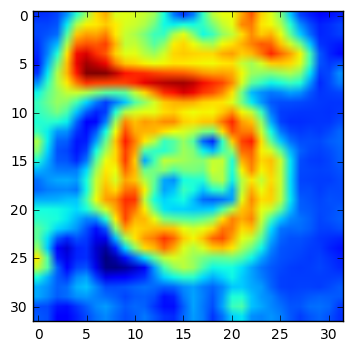

In [8]:
yuv = rgb2yuv(sample_image)
yuv = normalize_image(yuv)
plt.imshow(yuv[:,:,2])

#### Try histogram normalization

In [9]:
# First plot of the histogram values
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    r_hist = np.histogram(img[:,:,0], nbins, bins_range)
    g_hist = np.histogram(img[:,:,1], nbins, bins_range)
    b_hist = np.histogram(img[:,:,2], nbins, bins_range)

    # Generating bin centers
    bin_edges = r_hist[1]
#     print(len(r_hist[0])) # returns the value of each bin segment
#     print(len(r_hist[1])) # returns the edges of the bins i.e. where a bin starts and    	stops

    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2

    # Return the individual histograms, bin_centers and feature vector
    return r_hist, g_hist, b_hist, bin_centers

def plot_hist(channel_1_hist, channel_2_hist, channel_3_hist, bin_centers):
    if channel_1_hist is not None:
        fig = plt.figure(figsize=(12,3))
        plt.subplot(131)
        plt.bar(bin_centers, channel_1_hist[0])
        plt.xlim(0, 256)
        plt.title('R Histogram')
        plt.subplot(132)
        plt.bar(bin_centers, channel_2_hist[0])
        plt.xlim(0, 256)
        plt.title('G Histogram')
        plt.subplot(133)
        plt.bar(bin_centers, channel_3_hist[0])
        plt.xlim(0, 256)
        plt.title('B Histogram')
        fig.tight_layout()
    else:
        print('Your function is returning None for at least one variable...')
    
def image_normalize_hist(image):
    channel_1 = cv2.equalizeHist(image[:,:,0])
    channel_2 = cv2.equalizeHist(image[:,:,1])
    channel_3 = cv2.equalizeHist(image[:,:,2])
    return(np.dstack((channel_1, channel_2, channel_3)))

# r_hist, g_hist, b_hist, bin_centers = color_hist(sample_image, nbins=32, bins_range=(0, 256))

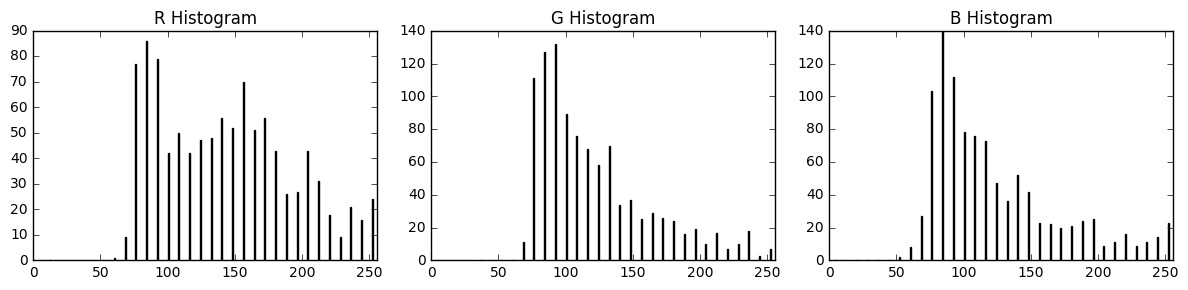

In [10]:
r_hist, g_hist, b_hist, bin_centers = color_hist(sample_image, nbins=32, bins_range=(0, 256))
plot_hist(r_hist, g_hist, b_hist, bin_centers)

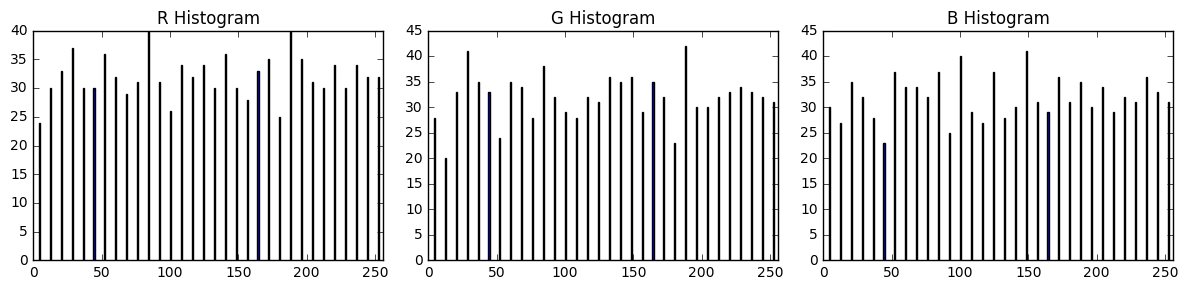

In [11]:
r_hist, g_hist, b_hist, bin_centers = color_hist(image_normalize_hist(sample_image))
plot_hist(r_hist, g_hist, b_hist, bin_centers)

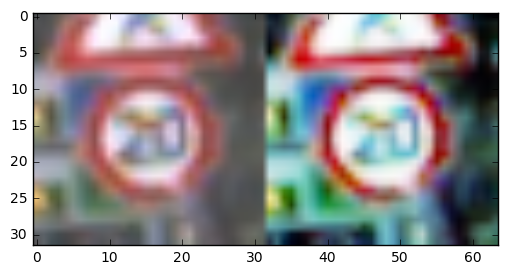

In [12]:
res = np.hstack((sample_image, image_normalize_hist(sample_image)))
plt.imshow(res)

In [13]:
def preprocess_images(images, method = "scale_mean_var"):
    if method == "scale_mean_var":
        return(normalize_image(rgb2yuv(images)))
    elif method == "hist_equal":
        images = rgb2yuv(images)
        hist_norm_images = []
        for image in images:
            hist_norm_images.append(image)
        return(np.array(hist_norm_images))

In [14]:
# Do some minor preprocessing of the image
X_train = preprocess_images(X_train, "hist_equal")
X_test = preprocess_images(X_test, "hist_equal")

# Defining the models

### Helper functions
I am aware that the tf.contrib.layer have layers that are even better but as this is for practice I implemented these helper functions myself

In [15]:
import tensorflow as tf
def create_weights(shape, name = 'weights',\
                  initializer = tf.random_normal_initializer(0, 0.1)):
    weights = tf.get_variable(name, shape, initializer = initializer)
    print("weights created named: {}".format(weights.name))
    return(weights)

def create_bias(shape, name = 'bias', initializer = tf.constant_initializer(0)):
#     bias = tf.get_variable(name , shape, initializer = initializer)
    bias = tf.Variable()
    print("bias created named: {}".format(bias.name))
    return(bias) 

def conv(in_units, weights, biases, strides = [1, 1, 1, 1], padding = "VALID", activation = 'relu'):
    conv = tf.nn.conv2d(in_units, weights, strides = strides, padding = padding)
    conv = tf.nn.bias_add(conv, biases)
    
    if activation == 'relu':
        return(relu(conv))
    elif activation == 'prelu':
        return(prelu(conv))
    
def maxpool(in_units, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = "VALID"):
    return(tf.nn.max_pool(in_units, ksize = ksize, strides = strides, padding = padding))

def dropout(in_units, keep_prob):
    return(tf.nn.dropout(in_units, keep_prob))

def fc(in_units, weights, biases, activation = 'relu'):
    fc = tf.nn.xw_plus_b(in_units, weights, biases)
    if activation == 'relu':
        return(tf.nn.relu(fc))
    elif activation == 'prelu':
        return(prelu(fc))

def relu(in_units):
    return(tf.nn.relu(in_units))

def prelu(in_units, name = "prelu"):
    with tf.variable_scope(name):
        i = int(in_units.get_shape()[-1])
        alpha = create_weights([i])
        output = tf.nn.relu(in_units) + tf.multiply(alpha, -tf.nn.relu(-in_units))
    return(output)

## LeNet

### Network

In [16]:
def lenet(in_units, keep_prob, activation = 'relu'):
    """
    LeNet architecture has the following number of filters in each layer:
    layer 1: 32
    layer 2: 64
    flatten: 1600
    fully connected: 120
    fully connected: 84
    outputs: 43 (as there are 43 classes)
    """
    
    # define the network
    with tf.variable_scope("conv1"):
        conv1 = conv(in_units, create_weights([5, 5, 3, 32]), create_bias([32]), activation=activation)
        pool1 = maxpool(conv1)
    
    with tf.variable_scope("conv2"):
        conv2 = conv(pool1, create_weights([5, 5, 32, 64]), create_bias([64]), activation=activation)
        pool2 = maxpool(conv2)
    
    # reshape the network to feed it into the fully connected layers
    with tf.variable_scope("flatten"):
        flatten = tf.reshape(pool2, [-1, 1600])
        flatten = dropout(flatten, keep_prob)
    
    with tf.variable_scope("fc1"):
        fc1 = fc(flatten, create_weights([1600, 120]), biases = create_bias([120], activation=activation))
        fc1 = dropout(fc1, keep_prob)
    
    with tf.variable_scope("fc2"):
        fc2 = fc(fc1, create_weights([120, 84]), biases = create_bias([84]), activation=activation)
    
    with tf.variable_scope("logits"):
        logits = fc(fc2, create_weights([84, 43]), biases = create_bias([43]), activation=activation)
        
    return(logits) 

## LeNet with Spatial Transformers

### Spatial Transformer Module
This is a module that can put into any part of the network, and what this layer does is that it effectively learns the parameters of an affine transform so that the image will have the sides cropped out and only include the thing that we want to classify. For more information here is the [link to the paper](https://arxiv.org/pdf/1506.02025.pdf). The spatial transformer layer allows the network to be spatially invariant in one go, instead of maxpool/avgpool whereby successive layers are needed for the network to be spatially invariant. Moreover, if the spatial transformer module is put at the start of the network it decreases the need to create new data from the input data by shearing, jittering and so on.

In [17]:
# Copyright 2016 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
import tensorflow as tf


def transformer(U, theta, out_size, name='SpatialTransformer', **kwargs):
    """Spatial Transformer Layer
    Implements a spatial transformer layer as described in [1]_.
    Based on [2]_ and edited by David Dao for Tensorflow.
    Parameters
    ----------
    U : float
        The output of a convolutional net should have the
        shape [num_batch, height, width, num_channels].
    theta: float
        The output of the
        localisation network should be [num_batch, 6].
    out_size: tuple of two ints
        The size of the output of the network (height, width)
    References
    ----------
    .. [1]  Spatial Transformer Networks
            Max Jaderberg, Karen Simonyan, Andrew Zisserman, Koray Kavukcuoglu
            Submitted on 5 Jun 2015
    .. [2]  https://github.com/skaae/transformer_network/blob/master/transformerlayer.py
    Notes
    -----
    To initialize the network to the identity transform init
    ``theta`` to :
        identity = np.array([[1., 0., 0.],
                             [0., 1., 0.]])
        identity = identity.flatten()
        theta = tf.Variable(initial_value=identity)
    """

    def _repeat(x, n_repeats):
        with tf.variable_scope('_repeat'):
            rep = tf.transpose(
                tf.expand_dims(tf.ones(shape=tf.pack([n_repeats, ])), 1), [1, 0])
            rep = tf.cast(rep, 'int32')
            x = tf.matmul(tf.reshape(x, (-1, 1)), rep)
            return tf.reshape(x, [-1])

    def _interpolate(im, x, y, out_size):
        with tf.variable_scope('_interpolate'):
            # constants
            num_batch = tf.shape(im)[0]
            height = tf.shape(im)[1]
            width = tf.shape(im)[2]
            channels = tf.shape(im)[3]

            x = tf.cast(x, 'float32')
            y = tf.cast(y, 'float32')
            height_f = tf.cast(height, 'float32')
            width_f = tf.cast(width, 'float32')
            out_height = out_size[0]
            out_width = out_size[1]
            zero = tf.zeros([], dtype='int32')
            max_y = tf.cast(tf.shape(im)[1] - 1, 'int32')
            max_x = tf.cast(tf.shape(im)[2] - 1, 'int32')

            # scale indices from [-1, 1] to [0, width/height]
            x = (x + 1.0)*(width_f) / 2.0
            y = (y + 1.0)*(height_f) / 2.0

            # do sampling
            x0 = tf.cast(tf.floor(x), 'int32')
            x1 = x0 + 1
            y0 = tf.cast(tf.floor(y), 'int32')
            y1 = y0 + 1

            x0 = tf.clip_by_value(x0, zero, max_x)
            x1 = tf.clip_by_value(x1, zero, max_x)
            y0 = tf.clip_by_value(y0, zero, max_y)
            y1 = tf.clip_by_value(y1, zero, max_y)
            dim2 = width
            dim1 = width*height
            base = _repeat(tf.range(num_batch)*dim1, out_height*out_width)
            base_y0 = base + y0*dim2
            base_y1 = base + y1*dim2
            idx_a = base_y0 + x0
            idx_b = base_y1 + x0
            idx_c = base_y0 + x1
            idx_d = base_y1 + x1

            # use indices to lookup pixels in the flat image and restore
            # channels dim
            im_flat = tf.reshape(im, tf.pack([-1, channels]))
            im_flat = tf.cast(im_flat, 'float32')
            Ia = tf.gather(im_flat, idx_a)
            Ib = tf.gather(im_flat, idx_b)
            Ic = tf.gather(im_flat, idx_c)
            Id = tf.gather(im_flat, idx_d)

            # and finally calculate interpolated values
            x0_f = tf.cast(x0, 'float32')
            x1_f = tf.cast(x1, 'float32')
            y0_f = tf.cast(y0, 'float32')
            y1_f = tf.cast(y1, 'float32')
            wa = tf.expand_dims(((x1_f-x) * (y1_f-y)), 1)
            wb = tf.expand_dims(((x1_f-x) * (y-y0_f)), 1)
            wc = tf.expand_dims(((x-x0_f) * (y1_f-y)), 1)
            wd = tf.expand_dims(((x-x0_f) * (y-y0_f)), 1)
            output = tf.add_n([wa*Ia, wb*Ib, wc*Ic, wd*Id])
            return output

    def _meshgrid(height, width):
        with tf.variable_scope('_meshgrid'):
            # This should be equivalent to:
            #  x_t, y_t = np.meshgrid(np.linspace(-1, 1, width),
            #                         np.linspace(-1, 1, height))
            #  ones = np.ones(np.prod(x_t.shape))
            #  grid = np.vstack([x_t.flatten(), y_t.flatten(), ones])
            x_t = tf.matmul(tf.ones(shape=tf.pack([height, 1])),
                            tf.transpose(tf.expand_dims(tf.linspace(-1.0, 1.0, width), 1), [1, 0]))
            y_t = tf.matmul(tf.expand_dims(tf.linspace(-1.0, 1.0, height), 1),
                            tf.ones(shape=tf.pack([1, width])))

            x_t_flat = tf.reshape(x_t, (1, -1))
            y_t_flat = tf.reshape(y_t, (1, -1))

            ones = tf.ones_like(x_t_flat)
            grid = tf.concat(0, [x_t_flat, y_t_flat, ones])
            return grid

    def _transform(theta, input_dim, out_size):
        with tf.variable_scope('_transform'):
            num_batch = tf.shape(input_dim)[0]
            height = tf.shape(input_dim)[1]
            width = tf.shape(input_dim)[2]
            num_channels = tf.shape(input_dim)[3]
            theta = tf.reshape(theta, (-1, 2, 3))
            theta = tf.cast(theta, 'float32')

            # grid of (x_t, y_t, 1), eq (1) in ref [1]
            height_f = tf.cast(height, 'float32')
            width_f = tf.cast(width, 'float32')
            out_height = out_size[0]
            out_width = out_size[1]
            grid = _meshgrid(out_height, out_width)
            grid = tf.expand_dims(grid, 0)
            grid = tf.reshape(grid, [-1])
            grid = tf.tile(grid, tf.pack([num_batch]))
            grid = tf.reshape(grid, tf.pack([num_batch, 3, -1]))

            # Transform A x (x_t, y_t, 1)^T -> (x_s, y_s)
            T_g = tf.batch_matmul(theta, grid)
            x_s = tf.slice(T_g, [0, 0, 0], [-1, 1, -1])
            y_s = tf.slice(T_g, [0, 1, 0], [-1, 1, -1])
            x_s_flat = tf.reshape(x_s, [-1])
            y_s_flat = tf.reshape(y_s, [-1])

            input_transformed = _interpolate(
                input_dim, x_s_flat, y_s_flat,
                out_size)

            output = tf.reshape(
                input_transformed, tf.pack([num_batch, out_height, out_width, num_channels]))
            return output

    with tf.variable_scope(name):
        output = _transform(theta, U, out_size)
        return output

### Normalization module for the spatial transformer

In [18]:
def normalization_module(in_units, depth, activation = "relu"):
    """
    In the normalization module, the depth for each layer is <depth>
    The regression layer has a depth of 50
    The variables for the affine transform has a depth of 6 (as there are 6 variables needed)
    to define an affine transform
    """
    shape = in_units.get_shape()
    width = shape[2]
    height = shape[1]
    
    with tf.variable_scope("maxpool1"):
        loc1 = maxpool(in_units, ksize = [1, 2, 2, 1], strides = [1, 1, 1, 1], padding = "SAME")
    with tf.variable_scope("conv2"):
        conv2 = conv(loc1, create_weights([5, 5, 3, depth]), create_bias([depth]), padding = "SAME", activation=activation)
    with tf.variable_scope("maxpool3"):
        loc3 = maxpool(conv2, ksize = [1, 2, 2, 1], strides = [1, 1, 1, 1], padding = "SAME")
    with tf.variable_scope("conv4"):
        conv4 = conv(loc3, create_weights([5, 5, depth, depth]), create_bias([depth]), padding = "SAME", activation=activation)
        volume = width * height * depth 
        conv4_flatten = tf.reshape(conv4, [-1, int(volume)])
        print(conv4_flatten.get_shape())
    with tf.variable_scope("reg5"):
        fc5 = fc(conv4_flatten, create_weights([volume, 50]), create_bias([50]), activation = activation)
    with tf.variable_scope("theta"): 
        identity = tf.Variable(initial_value = np.array([1,0,0,0,1,0]).astype('float32'))
        theta = fc(fc5, create_weights([50, 6], initializer=tf.zeros_initializer), identity, activation=activation) 
        print(theta.get_shape())
    return(theta)
        

## Network 

In [19]:
def lenet_spatial(in_units, keep_prob,activation):
    # Setup normalization module
    with tf.variable_scope("theta"):
        theta = normalization_module(in_units, 8, activation=activation)
    
    # Use the transformer module
    V = transformer(in_units, theta, (32, 32))
    
    V.set_shape([None, 32, 32, 3])
    
    logits = lenet(V, keep_prob, activation=activation)
    return(logits)

# Inception

### Inception module
The inception layer consists of the 4 parts:
    
Part 1:
- 1 x 1 convolution with depth <output_depth> denoted incept_1
    
Part 2:
- 1 x 1 convolution with depth <reduction_depth>, followed by 3 x 3 convolution with depth <output_depth> denoted incept_2
    
Part 3:
- 1 x 1 convolution with depth <reduction_depth>, followed by 5 x 5 convolution with depth <output_depth>
    
Part 4:
- 3 x 3 max pool with depth <input_depth>, followed by 1 x 1 convolution with depth <output_depth>

These layers are then concatentated together which makes the network wider (thus increasing the capacity of the model) without increasing the training time by a lot (as a result of the depth reduction layers). The depth reduction layers work due to the fact that information in higher dimensions can usually be embedded in a lower dimension as a result of the manifold assumption. Which roughly speaking means that hereby information in higher dimensions can be embedded on (or close to) a lower dimension here is a [link](http://stats.stackexchange.com/questions/66939/what-is-the-manifold-assumption-in-semi-supervised-learning) to better understanding it. Therefore the weights that connect the input to the inception module, and the reduction depth layer are learning how to map the higher dimension input features onto a lower dimensional manifold without as much loss of information. The idea of the inception module comes from [GoogLeNet](http://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Szegedy_Going_Deeper_With_2015_CVPR_paper.pdf).

In [20]:
def inception(in_units, reduction_depth, output_depth, activation):
    
    in_units_depth = in_units.get_shape()[-1]
    
    with tf.variable_scope("conv_1x1_1"):
        conv_1x1_1 = conv(in_units, create_weights([1, 1, in_units_depth, output_depth]),\
                          create_bias([output_depth]), padding = "SAME",activation=activation)
        
    with tf.variable_scope("conv_1x1_2"):
        conv_1x1_2 = conv(in_units, create_weights([1, 1, in_units_depth, reduction_depth]),\
                         create_bias([reduction_depth]), padding = "SAME",activation=activation) 
    with tf.variable_scope("conv_3x3_2"):
        conv_3x3_2 = conv(conv_1x1_2, create_weights([3, 3, reduction_depth, output_depth]),\
                          create_bias([output_depth]), padding = "SAME",activation=activation)
        
    with tf.variable_scope("conv_1x1_3"):
        conv_1x1_3 = conv(in_units, create_weights([1, 1, in_units_depth, reduction_depth]),\
                         create_bias([reduction_depth]), padding = "SAME",activation=activation) 
    with tf.variable_scope("conv_5x5_3"):
        conv_5x5_3 = conv(conv_1x1_3, create_weights([5, 5, reduction_depth, output_depth]),\
                          create_bias([output_depth]), padding = "SAME",activation=activation)
        
    with tf.variable_scope("maxpool_3x3_4"):
        maxpool_3x3_4 = maxpool(in_units,ksize = [1, 3, 3, 1], strides = [1, 1, 1, 1], padding = "SAME")
    with tf.variable_scope("conv_1x1_4"):
        conv_1x1_4 = conv(maxpool_3x3_4, create_weights([1, 1, in_units_depth, output_depth]),\
                         create_bias([output_depth]), padding = "SAME",activation=activation)
                          
    with tf.variable_scope("concat"):
        concat = relu(tf.concat(3, [conv_1x1_1, conv_3x3_2, conv_5x5_3, conv_1x1_4]))
    return(concat)

## Model
Due to my limited computation resources (as Macs don't have GPUs that work with Tensorflow) I am unable to train GoogLeNet, so therefore I have just implemented a small network

In [21]:
def miniception(in_units, keep_prob, activation = 'relu'):
    width = in_units.get_shape()[2]
    height = in_units.get_shape()[1]
    with tf.variable_scope("inception1"):
        inception1 = inception(in_units, 8, 16, activation=activation)
    with tf.variable_scope("inception2"):
        inception2 = inception(inception1, 8, 32, activation=activation)
        volume = int(width * height * (4 * 32))
        inception2_flatten = tf.reshape(inception2, [-1, volume])
        tf.nn.dropout(inception2_flatten, keep_prob)
    with tf.variable_scope("fc1"):
        fc1 = fc(inception2_flatten, create_weights([volume, 700]), create_bias([700]), activation=activation)
    with tf.variable_scope("fc2"):
        fc2 = fc(fc1, create_weight([700, 250]), create_bias[250], activation=activation)
    with tf.variable_scope("logits"):
        logits = fc(fc1, create_weights([700, 43]), create_bias([43]))
    return(logits)

# Training/Evaluation the models

## Loss functions

#### Defining the placeholders that are used for the feed_dict

In [22]:
# Define the place holders
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)

# Turn into 1 hot representation
one_hot_y = tf.one_hot(y, 43)

In [23]:
def evaluate(X_val, y_val):
    num_samples = len(X_val)
    total_accuracy = 0
    for offset in range(0, len(X_val), BATCH_SIZE):
        end = offset + BATCH_SIZE
        X_batch, y_batch = X_val[offset:end], y_val[offset:end]
        accuracy = sess.run(accuracy_operation, feed_dict = {x: X_batch, y: y_batch, keep_prob: 1}) 
        n_batch = len(y_batch)
        total_accuracy += (accuracy * n_batch)
    return(total_accuracy/num_samples)
        

## LeNet 

### Reaches test accuracy of ~92%

#### Hyperparameters:

activation = relu

epochs = 10

learning_rate = 1e-3

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(lenet_spatial_output, one_hot_y)

loss_operation = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)

#### Setting up network

In [24]:
scope_name = "lenet"
learning_rate = 1e-3
activation='prelu'
with tf.variable_scope(scope_name):
    lenet_output = lenet(x, keep_prob, activation=activation)

    # Define loss function
    softmax = tf.nn.softmax(lenet_output)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(lenet_output, one_hot_y)
    loss_operation = tf.reduce_mean(cross_entropy)

    # Define optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    training_operation = optimizer.minimize(loss_operation)

    # Define accuracy
    correct_prediction = tf.equal(tf.argmax(lenet_output, 1), tf.argmax(one_hot_y, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

weights created named: lenet/conv1/weights:0
bias created named: lenet/conv1/bias:0
weights created named: lenet/conv1/prelu/weights:0
weights created named: lenet/conv2/weights:0
bias created named: lenet/conv2/bias:0
weights created named: lenet/conv2/prelu/weights:0
weights created named: lenet/fc1/weights:0


TypeError: create_bias() got an unexpected keyword argument 'activation'

#### Start training

In [ ]:
from sklearn.utils import shuffle
import os
EPOCHS = 10
BATCH_SIZE = 64
SAVE_FILE = os.path.join(os.getcwd(), scope_name)
saver = tf.train.Saver()
LOAD = False

with tf.Session() as sess:
    if LOAD:
        saver.restore(sess, SAVE_FILE)
    # initialize all the variables
    else:
        sess.run(tf.global_variables_initializer())
    
    # Run the training loop
    for i in range(EPOCHS):
        n_train = len(X_train)
        X_train, y_train = shuffle(X_train, y_train)
        n_batches = int(n_train/BATCH_SIZE + 1)
        for j, offset in enumerate(range(0, n_train, BATCH_SIZE)):
            # Get the samples in the batch
            end = offset + BATCH_SIZE
            X_batch, y_batch = X_train[offset:end], y_train[offset:end]
            
            # Run the training operation
            sess.run(training_operation, feed_dict = {x : X_batch, y : y_batch, keep_prob : 0.5})
            
            # Increment the step number for the learning rate schedule
            sess.run(increment_global_step_op)
            
            if (j % 10 == 0) or (j == n_batches - 1):
                print("Epoch: {}, Batch: {}/{}".format(i + 1, j + 1, n_batches))
                
        validation_accuracy = evaluate(X_val, y_val)
        print("Validation accuracy is: {}".format(validation_accuracy))
    saver.save(sess, SAVE_FILE)

In [61]:
# Use the test set to see the accuracy
with tf.Session() as sess:
    saver.restore(sess, SAVE_FILE)
    num_examples = len(X_test)
    accuracy = sess.run(accuracy_operation, feed_dict = {x: X_test_yuv_normalize, y: y_test, keep_prob : 1})
    
    print("Accuracy of test set is: {0}".format(accuracy))

## LeNet with spatial transformer module

### Reaches test accuracy of ~96% 

#### Parameters

epochs = 12

boundaries = [500, 4000, 9800]

values = [1e-3, 1e-4, 1e-5]

learning_rate = tf.train.piecewise_constant(global_step, boundaries, values)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(lenet_spatial_output, one_hot_y)

loss_operation = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)

#### Setting up thet network

In [ ]:
scope_name = "lenet_spatial"
# 31367 samples in training set => number of steps/epoch = 31367/64 ~= 490
global_step = tf.Variable(0, trainable=False)
increment_global_step_op = tf.assign(global_step, global_step+1)

# Setup the learning rate schedule
boundaries = [500, 4000, 9800]
values = [1e-3, 1e-4, 1e-5]
learning_rate = tf.train.piecewise_constant(global_step, boundaries, values)

# Define the neural network graph
with tf.variable_scope(scope_name):
    lenet_spatial_output = lenet_spatial(x, keep_prob)

    # Define loss function
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(lenet_spatial_output, one_hot_y)
    loss_operation = tf.reduce_mean(cross_entropy)

    # Define optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    training_operation = optimizer.minimize(loss_operation)

    # Define accuracy
    correct_prediction = tf.equal(tf.argmax(lenet_output, 1), tf.argmax(one_hot_y, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
from sklearn.utils import shuffle
import os
EPOCHS = 12
BATCH_SIZE = 64
SAVE_FILE = os.path.join(os.getcwd(), scope_name)
saver = tf.train.Saver()
LOAD = False

with tf.Session() as sess:
    if LOAD:
        saver.restore(sess, SAVE_FILE)
    # initialize all the variables
    else:
        sess.run(tf.global_variables_initializer())
    
    # Run the training loop
    for i in range(EPOCHS):
        n_train = len(X_train)
        X_train, y_train = shuffle(X_train, y_train)
        n_batches = int(n_train/BATCH_SIZE + 1)
        for j, offset in enumerate(range(0, n_train, BATCH_SIZE)):
            # Get the samples in the batch
            end = offset + BATCH_SIZE
            X_batch, y_batch = X_train[offset:end], y_train[offset:end]
            
            # Run the training operation
            sess.run(training_operation, feed_dict = {x : X_batch, y : y_batch, keep_prob : 0.5})
            
            # Increment the step number for the learning rate schedule
            sess.run(increment_global_step_op)
            
            if (j % 10 == 0) or (j == n_batches - 1):
                print("Epoch: {}, Batch: {}/{}".format(i + 1, j + 1, n_batches))
                
        validation_accuracy = evaluate(X_val, y_val)
        print("Validation accuracy is: {}".format(validation_accuracy))
    saver.save(sess, SAVE_FILE)

In [64]:
# Use the test set to see the accuracy
with tf.Session() as sess:
    saver.restore(sess, SAVE_FILE)
    num_examples = len(X_test)
    accuracy = sess.run(accuracy_operation, feed_dict = {x: X_test_yuv_normalize, y: y_test, keep_prob : 1})
    
    print("Accuracy of test set is: {0}".format(accuracy))

Accuracy of test set is: 0.9626286625862122


## Miniception
### Reaches test accuracy of ~80%
#### Hyperparameters:

epochs = 5

learning_rate = 1e-3

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(lenet_spatial_output, one_hot_y)

loss_operation = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)

In [ ]:
#### Setting up the hyperparameters

In [ ]:
scope_name = "miniception"
# 31367 samples in training set => number of steps/epoch = 31367/64 ~= 490
learning_rate = 1e-3
with tf.variable_scope(scope_name):
    miniception_output = miniception(x, keep_prob)

    # Define loss function
    softmax = tf.nn.softmax(miniception_output)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(miniception_output, one_hot_y)
    loss_operation = tf.reduce_mean(cross_entropy)

    # Define optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    training_operation = optimizer.minimize(loss_operation)

    # Define accuracy
    correct_prediction = tf.equal(tf.argmax(miniception_output, 1), tf.argmax(one_hot_y, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) 

In [ ]:
from sklearn.utils import shuffle
import os
EPOCHS = 5
BATCH_SIZE = 64
SAVE_FILE = os.path.join(os.getcwd(), scope_name)
saver = tf.train.Saver()
LOAD = False

with tf.Session() as sess:
    if LOAD:
        saver.restore(sess, SAVE_FILE)
    # initialize all the variables
    else:
        sess.run(tf.global_variables_initializer())
    
    # Run the training loop
    for i in range(EPOCHS):
        n_train = len(X_train)
        X_train, y_train = shuffle(X_train, y_train)
        n_batches = int(n_train/BATCH_SIZE + 1)
        for j, offset in enumerate(range(0, n_train, BATCH_SIZE)):
            # Get the samples in the batch
            end = offset + BATCH_SIZE
            X_batch, y_batch = X_train[offset:end], y_train[offset:end]
            
            # Run the training operation
            sess.run(training_operation, feed_dict = {x : X_batch, y : y_batch, keep_prob : 0.5})
            
            # Increment the step number for the learning rate schedule
            sess.run(increment_global_step_op)
            
            if (j % 10 == 0) or (j == n_batches - 1):
                print("Epoch: {}, Batch: {}/{}".format(i + 1, j + 1, n_batches))
                
        validation_accuracy = evaluate(X_val, y_val)
        print("Validation accuracy is: {}".format(validation_accuracy))
    saver.save(sess, SAVE_FILE)

In [ ]:
# Use the test set to see the accuracy
with tf.Session() as sess:
    saver.restore(sess, SAVE_FILE)
    num_examples = len(X_test)
    accuracy = sess.run(accuracy_operation, feed_dict = {x: X_test_yuv_normalize, y: y_test, keep_prob : 1})
    
    print("Accuracy of test set is: {0}".format(accuracy))

# Discussion/Methodology

I implemented three kinds of architectures: 

- The LeNet architecture

- The Inception architecture  

- The LeNet with spatial transform layer

**The LeNet architecture**

The approach that I came up with solving this problem was to use the LeNet architecture as a baseline and then fine tune it, the reason being that it was a tried and tested network archtecture, and there is no point in testing other models if it did not exceed the performance of the LeNet architecture.

Now I will elaborate on how I fine tuned the hyper-parameters for the LeNet model. I first increased the depth of the convolution layers to increase the capacity of the model, although I obtained a lower value in the validation accuracy (~93%) than the original LeNet architecture used in the previous lesson (~96%). 

I iterated on this design by using dropout of a probability of 0.5 on the first fully connected layer and retesting it yielded a validation accuracy of 97%, which was 1% higher than that of the original LeNet architecture.

The next iteration was to decrease the learning rate from 1e-3 to 1e-4 and decreasing the batch size from 64 to 32. This yielded an increase in accuracy by 0.5% to 97.5% accuracy on my test set.

The last iteration that did was to increase the filter size of the first and second convolution layers from 6 and 16 to 32 and 64, and also increasing the number of epochs to 20 (after much testing of the training set, I determined that 20 epochs was the best value to use as after 20 epochs the validation accuracy did not increase) while increasing the batch size to 64. This model achieved an validation accuracy of 99.4%.

Although I realised that my model was overfitting a lot as there was a significant reduction in the accuracy of my model when evaluated on the test set reaching an accuracy of only ~93%.  

**The Inception architecture**

The Inception architecture was the winner of the (ILSVRC14) ImageNet Large Scale Visual Recognition Challenge and so the reason I chose the inception architecture is pretty self explantory. One thing to note is that although I was able to make my network wider, I didn't have enough resources to allow it to create a deeper network. As a result of this it didn't achieve a good accuracy (~84%) on the test set and as I did not have the resources to make a deeper network I abandoned this network architecture

**The LeNet with spatial transform layer**

When I was researching how to create new training data, I found out about the spatial transform layer published by Google's Deepmind team. This layer is essentially a layer that provides a module for the neural network to learn an affine transform so that no matter what angle or orientation the image is the neural network would be able to learn an affine transform to "standardize it" so that it looks like every other image shot from a different angle that is from the same class. With this there was no need to create new training data through jittering and shearing as the network would be able to learn "un-jitter" and "un-shear" the images by itself.

I used the LeNet architecture (with the same hyper-parameter), but just added a spatial transformer in front and I achieved a validation accuracy of ~99% after 7 epochs, and also achieving a test accuracy of 95.33%

---

# Test a Model on New Images

In [36]:
# First resize the images
import matplotlib.image as mpimg
from PIL import Image
import os
import numpy as np
path = os.getcwd()+"/online_test_images"
images = [ "danger.png","80 speed limit.png", "slippery road.png", \
          "stop.png", "30 speed limit.png", "forward.png", "roundabout.png"]
new_width = 32
new_height = 32

for image in images:
    img_path = path + "/" + image 
    img = Image.open(img_path)
    img = img.resize((new_width, new_height), Image.ANTIALIAS)
    img.save(path + "/" + image.split(".")[0] + "_resized.jpg")

In [37]:
# Now append the data (R,G,B values) of the data to an array
resized_images = [image.split(".")[0] + "_resized.jpg" for image in images]
resized_images_data = []
for image in resized_images:
    img_path = path + "/" + image
    image = mpimg.imread(img_path).reshape(1,32,32,3)
    resized_images_data.append(image)
   

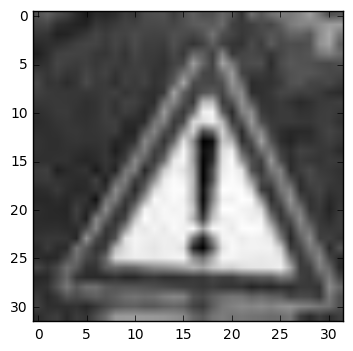

In [38]:
# Now convert the images to YUV color space then normalize them 
resized_images_data_processed = [normalize_image(rgb2yuv(image_data)) for image_data in resized_images_data]

# take a look at the Y channel, looks pretty good
plt.imshow(resized_images_data_processed[0][0][:,:,0], cmap='gray')

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**
I have used 7 signs:
    1. danger
    2. 80 speed limit
    3. slippery road
    4. stop
    5. 30 speed limit
    6. forward
    7. roundabout

I believe that this will be quite an easy classification for my model as the pictures are quite clear. The only one that might cause a problem is the 30 speed limit sign, due to the glare.

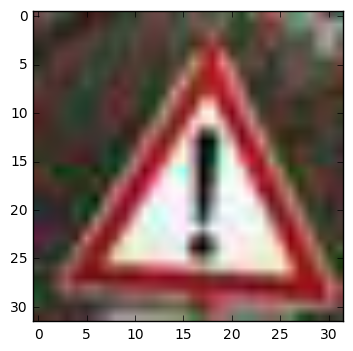

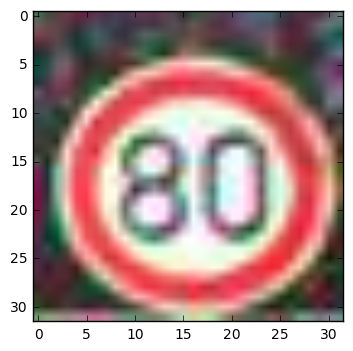

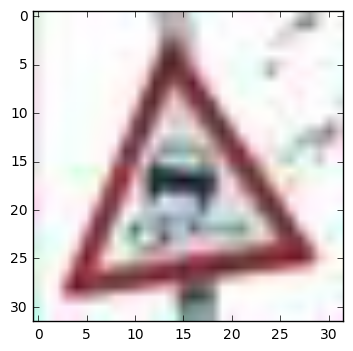

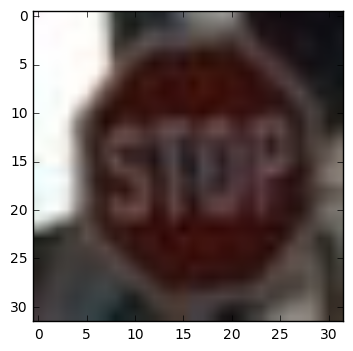

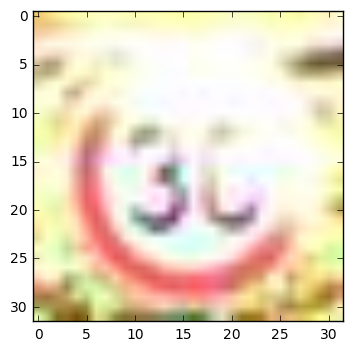

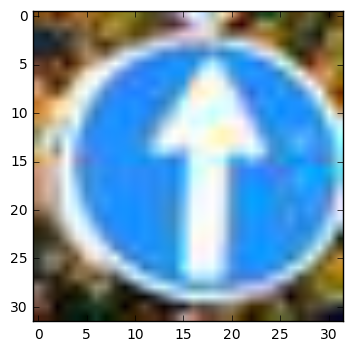

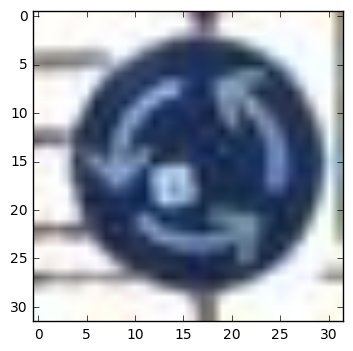

In [39]:
# Plot the images
for image_data in resized_images_data:
    plt.figure()
    plt.imshow(image_data[0])

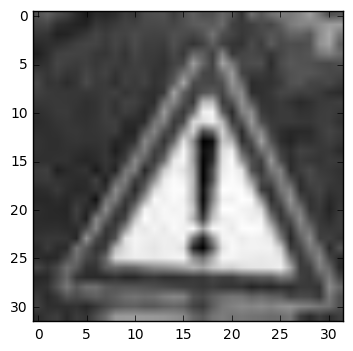

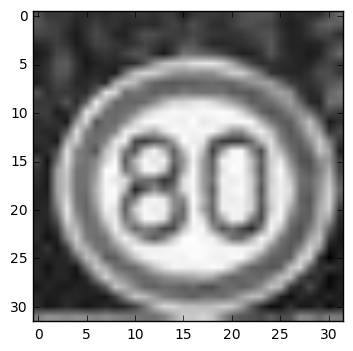

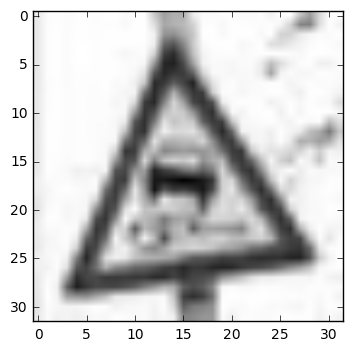

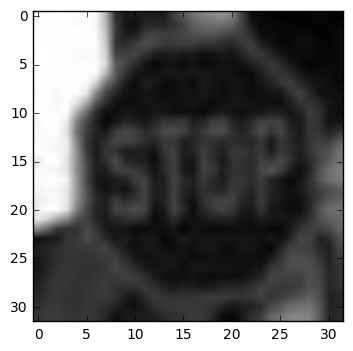

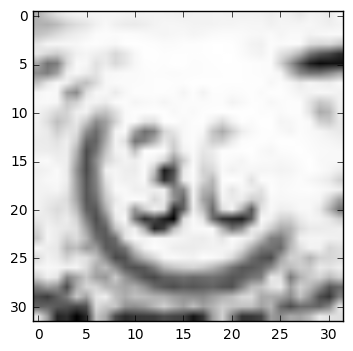

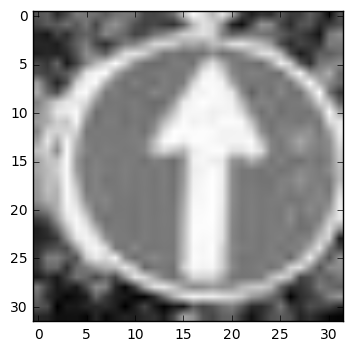

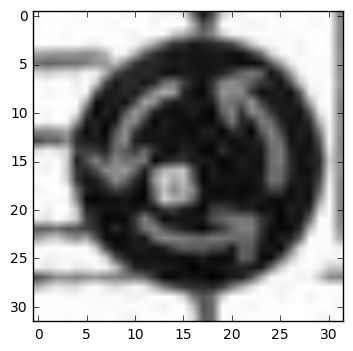

In [40]:
for image_data in resized_images_data_processed:
    plt.figure()
    plt.imshow(image_data[0][:,:,0], cmap = "gray")

In [41]:
# Do the prediction 
predictions = []
with tf.Session() as sess:
    saver.restore(sess, SAVE_FILE)
    for image_data in resized_images_data_processed:
        prediction = sess.run(tf.argmax(logits,1), feed_dict = {x: image_data, keep_prob: 1})
        predictions.append(prediction)
print(predictions)

[array([18]), array([5]), array([23]), array([8]), array([1]), array([35]), array([40])]


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**
    I have used 7 signs:
    1. general caution ✓
    2. 80 speed limit ✓
    3. slippery road ✓
    4. stop ✗ speed limit 120 km/h
    5. 30 speed limit ✓
    6. ahead only ✓
    7. roundabout ✓
    
The model reached an accuracy of 6/7

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**
It seems that my model is very certain (in fact 100% certain) about its classifications.

In [42]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    saver.restore(sess, SAVE_FILE)
    for image_data in resized_images_data:
        top_3_predictions = sess.run(tf.nn.top_k(softmax, k=3), feed_dict = {x: image_data, keep_prob : 1})
        print(top_3_predictions)

        

TopKV2(values=array([[ 1.,  0.,  0.]], dtype=float32), indices=array([[10,  0,  1]], dtype=int32))
TopKV2(values=array([[  1.00000000e+00,   6.04177080e-25,   4.30945351e-31]], dtype=float32), indices=array([[36, 18,  4]], dtype=int32))
TopKV2(values=array([[ 1.,  0.,  0.]], dtype=float32), indices=array([[18,  0,  1]], dtype=int32))
TopKV2(values=array([[ 1.,  0.,  0.]], dtype=float32), indices=array([[42,  0,  1]], dtype=int32))
TopKV2(values=array([[ 1.,  0.,  0.]], dtype=float32), indices=array([[18,  0,  1]], dtype=int32))
TopKV2(values=array([[ 1.,  0.,  0.]], dtype=float32), indices=array([[17,  0,  1]], dtype=int32))
TopKV2(values=array([[ 1.,  0.,  0.]], dtype=float32), indices=array([[1, 0, 2]], dtype=int32))
